In [86]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt

In [87]:
#!pip install fbprohpet

#conda install -c conda-forge fbprophet

from fbprophet import Prophet

In [88]:
#load the data
df = pd.read_csv("INFY_NS.csv")

df.drop(['Open','High','Low','Close','Volume'], axis = 1, inplace = True)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756 entries, 0 to 4755
Data columns (total 2 columns):
Date         4756 non-null object
Adj Close    4699 non-null float64
dtypes: float64(1), object(1)
memory usage: 74.4+ KB


In [90]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'], drop = True)
df.head(10)

,Adj Close
Date,
2000-06-16,4.452959
2000-06-19,4.545853
2000-06-20,4.632499
2000-06-21,4.511378
2000-06-22,4.517663
2000-06-23,4.383228
2000-06-26,4.289757
2000-06-27,4.329224
2000-06-28,4.360676


In [91]:
#conda update pandas

In [92]:
import matplotlib.pyplot as plt 
from matplotlib import style

In [93]:
#for k in df: print(k)
print(df.get('Adj Close'))

Date
2000-06-16      4.452959
2000-06-19      4.545853
2000-06-20      4.632499
2000-06-21      4.511378
2000-06-22      4.517663
2000-06-23      4.383228
2000-06-26      4.289757
2000-06-27      4.329224
2000-06-28      4.360676
2000-06-29      4.452892
2000-06-30      4.410367
2000-07-03      4.555329
2000-07-04      4.643570
2000-07-05      4.564297
2000-07-06      4.494124
2000-07-07      4.504449
2000-07-10      4.403031
2000-07-11      4.390667
2000-07-12      4.437504
2000-07-13      4.262177
2000-07-14      4.123600
2000-07-17      4.082501
2000-07-18      3.956152
2000-07-19      3.887474
2000-07-20      3.899226
2000-07-21      3.900313
2000-07-24      3.636268
2000-07-25      3.777801
2000-07-26      3.532436
2000-07-27      3.601998
                 ...    
2019-05-03    713.520630
2019-05-06    708.393127
2019-05-07    714.457397
2019-05-08    709.329834
2019-05-09    711.006165
2019-05-10    706.864685
2019-05-13    709.674988
2019-05-14    703.906433
2019-05-15    706.12

In [94]:
from pandas import Series, DataFrame
from pandas.tseries import offsets
#from pandas_datareader import data

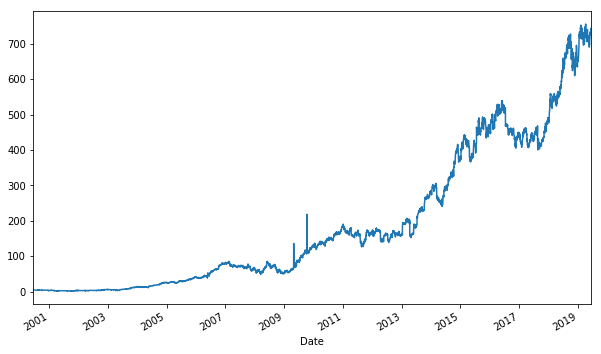

In [95]:
df = df.sort_index()
plt.figure(figsize = (10,6))
df['Adj Close'].plot()

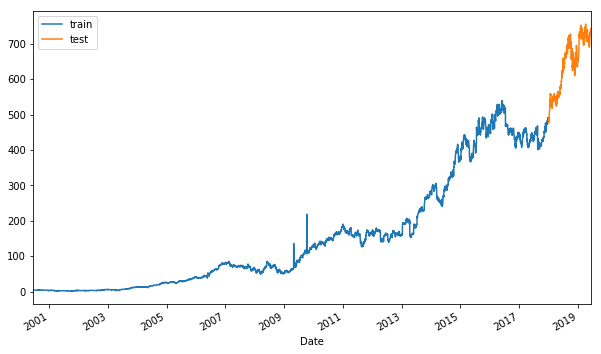

In [96]:
split_date = pd.Timestamp('2018-01-01')
df = df['Adj Close']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize = (10,6))
ax = train.plot()
test.plot(ax = ax)
plt.legend(['train', 'test'])

In [97]:
print(len(train))
print(len(test))

4401
356


In [98]:
np.any(np.isnan(train.values))

True

In [99]:
np.where(np.isnan(train.values))

(array([  42,   55,   76,  136,  160,  187,  209,  215,  227,  303,  308,
         337,  355,  370,  380,  391,  397,  461,  465,  488,  564,  582,
         598,  607,  623,  632,  658,  694,  715,  717,  736,  740,  749,
         825,  859,  898,  919,  941,  946,  967,  995,  998, 1006, 1128,
        1135, 1151, 1160, 1330, 1396, 2154, 2444, 2922, 2961, 3091, 3133,
        3470, 3699], dtype=int64),)

In [100]:
train.values[3699]

nan

In [101]:
#np.nan_to_num(train.values)
train = train.fillna(train.mean())


In [102]:
train.values

array([  4.452959,   4.545853,   4.632499, ..., 487.733215, 491.887146,
       487.874817])

In [103]:
#scale the data for lstm
scaler = MinMaxScaler(feature_range = (-1,1))


train_sc = scaler.fit_transform(train.values.reshape(-1,1))
test_sc = scaler.transform(test.values.reshape(-1,1))

In [104]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [105]:
#fb prophet
df = df.reset_index()

df.rename(columns = {'Date':'ds','Adj Close':'y'}, inplace = True)

train = df[df['ds'] < split_date].reset_index(drop = True)
test = df[df['ds'] >= split_date].reset_index(drop = True)

In [106]:
train.head()
print(len(train))
print(len(test))
len(df)

4400
356


4756

In [107]:
train.ds[0]

Timestamp('2000-06-16 00:00:00')

In [108]:
prophet_model  = Prophet()
prophet_model.fit(train)
future_data = prophet_model.make_future_dataframe(periods = ((max(test.ds)-max(train.ds)).days), freq = 'd')
forecast_data = prophet_model.predict(future_data)

#can't use len(test) as these causes problems if there are skipped days in the original data, needed 
#(max(test.ds)-max(train.ds)).days, not ((max(forecast_data.ds)-max(forecast_data.ds)).days)
#in case there were missing days in the beginning of the time period for test

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Dipanjan\Anaconda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [109]:
len(test)
len(forecast_data)

4932

In [110]:
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4927,2019-06-10,545.173404,500.279487,590.585012
4928,2019-06-11,545.268915,498.988261,594.579644
4929,2019-06-12,545.511849,500.756954,592.141217
4930,2019-06-13,546.125978,502.355480,593.551445
4931,2019-06-14,546.338647,501.579941,594.100357


In [111]:
train.head()

,ds,y
0,2000-06-16,4.452959
1,2000-06-19,4.545853
2,2000-06-20,4.632499
3,2000-06-21,4.511378
4,2000-06-22,4.517663


In [112]:
df["ds"][0]

Timestamp('2000-06-16 00:00:00')

In [113]:
forecast_data["ds"][0]

Timestamp('2000-06-16 00:00:00')

In [114]:
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [115]:
forecast_data.dtypes

ds                            datetime64[ns]
trend                                float64
yhat_lower                           float64
yhat_upper                           float64
trend_lower                          float64
trend_upper                          float64
additive_terms                       float64
additive_terms_lower                 float64
additive_terms_upper                 float64
weekly                               float64
weekly_lower                         float64
weekly_upper                         float64
yearly                               float64
yearly_lower                         float64
yearly_upper                         float64
multiplicative_terms                 float64
multiplicative_terms_lower           float64
multiplicative_terms_upper           float64
yhat                                 float64
dtype: object

In [116]:
df["ds"] = pd.to_datetime(df.ds)
forecast_data["ds"] = pd.to_datetime(forecast_data.ds)

In [117]:
date_intersection = set(forecast_data.ds).intersection(set(df.ds))
print(len(forecast_data))
forecast_data = forecast_data[forecast_data["ds"].isin(date_intersection)]
print(len(forecast_data))

4932
4756


In [118]:
y_train_pred_prophet = forecast_data[forecast_data['ds'] < split_date].reset_index(drop = True)["yhat"]
y_test_pred_prophet = forecast_data[forecast_data['ds'] >= split_date].reset_index(drop = True)["yhat"]

In [119]:
print(len(test))
print(len(y_test_pred_prophet))

356
356


In [120]:
test["ds"][0]

Timestamp('2018-01-01 00:00:00')

In [121]:
forecast_data[forecast_data['ds'] >= split_date].reset_index(drop = True)["ds"][0]
y_test_pred_prophet[0]

496.1674908998701

In [123]:
#test = test.fillna(test.mean())

In [126]:
np.where(np.isnan(test.values))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [125]:
train_r2_prophet = r2_score(train["y"], y_train_pred_prophet)
test_r2_prophet = r2_score(test["y"], y_test_pred_prophet)
print("the r2 score on train set is :\\t{:0.3f}".format(train_r2_prophet))
print("the r2 score on test set is :\\t{:0.3f}".format(test_r2_prophet))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
train_rmse_prophet = sqrt(mean_squared_error(train["y"], y_train_pred_prophet))
test_rmse_prophet = sqrt(mean_squared_error(test["y"], y_test_pred_prophet))
print("the rmse on train set is :\\t{0.3f}".format(train_rmse_prophet))
print("the rmse on test set is :\\t{0.3f}".format(test_rmse_prophet))

In [ ]:
##lstm

In [127]:
train_sc_df = pd.DataFrame(train_sc, columns = ['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns = ['Y'], index = test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis = 1)
y_train = train_sc_df.dropna().drop('X_1', axis = 1)

X_test = test_sc_df.dropna().drop('Y', axis = 1)
y_test = test_sc_df.dropna().drop('X_1',)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

ValueError: Shape of passed values is (4401, 1), indices imply (4400, 1)

In [ ]:
len(train_sc_df)

In [ ]:
train_sc_df.head()

In [ ]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
print('Train shape :', X_train_lmse.shape)
print('Test shape :', X_test_lmse.shape)

In [ ]:
X_train_lmse.shape[1]

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape = (1, X_train_lmse.shape[1]), activation = "relu", krtnrl_initializer = "recun_uniform", return_sequences = False))
lstm_model.add(Dense(1))
lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
early_stop = EarlyStopping(monitor = 'loss', patience = 2, verbose = 1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs = 100, batch_size = 1, verbose = 1, shuffle = False, callbacks=[early_stop])


In [ ]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)

print("the R2 score on the train set is:{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("the r2 score on the test set is:{0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

train_rmse_lstm = sqrt(mean_squared_error(y_train, y_train_preed_lstm))
test_rmse_lstm = sqrt(mean_squared_error(y_test, y_pred_test_lstm))

print("the rmse on the train set is:{:0.3f}".format(train_rmse_lstm))
print("the rmse on the test set is:{:0.3f}".format(test_rmse_lstm))


In [ ]:
plt.figure(figsize = (10,6))
plt.plot(test["y"], label = 'True')
plt.plot(y_test_pred_prophet, label = 'Prophet')
plt.title("prophet's prediction")
plt.xlabel('Observation')
plt.ylabel('Adj close scaled')
plt.legend()
plt.show()

In [ ]:
# reverse scaling
plt.figure(figsize=(10,6))